In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

Read the data from the .csv file into a `pandas.Dataframe`

In [2]:
df = pd.read_csv("data.csv")
df.shape

(1866783, 7)

In [3]:
df.head()

,[run number],isolation-chance,vaccination-start,wearing-mask-chance,[step],deaths,r0
0,2,0,0,0,0,0,0.0
1,5,0,0,0,0,0,0.0
2,7,0,0,0,0,0,0.0
3,3,0,0,0,0,0,0.0
4,4,0,0,0,0,0,0.0


Extract the data that is only relevant for the deaths. That is, we are only interested in the total number of dead people after every simulation. We can just take the maximal deaths count for every iteration.

In [4]:
deaths_df = df.groupby(
    ["[run number]", "isolation-chance", "vaccination-start", "wearing-mask-chance"]
)["deaths"].max()
deaths_df = deaths_df.reset_index().drop("[run number]", axis = 1)
deaths_df

,isolation-chance,vaccination-start,wearing-mask-chance,deaths
0,0,0,0,36
1,0,0,0,26
2,0,0,0,41
3,0,0,0,35
4,0,0,0,29
...,...,...,...,...
9675,100,210,100,7
9676,100,210,100,3
9677,100,210,100,4
9678,100,210,100,4


The dataset is reduced to 9680 (compared to 1866783). To preprocess the input features, we can standardize them (mean = 0, std = 1) and compute their interactions.

In [5]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree = 2, interaction_only = True))
])

Split the data into the independent variables (X) and the dependent variable (y).

In [6]:
X, y = deaths_df.drop("deaths", axis = 1), deaths_df["deaths"]

Transform the data using the pipeline from cell 5 and keep the feature names.

In [7]:
feature_names = X.columns
X_norm_interaction = pipeline.fit_transform(X)

poly_feature_names = pipeline.named_steps['poly'].get_feature_names_out(feature_names)
X_norm_interaction = pd.DataFrame(X_norm_interaction, columns=["Intercept"] + list(poly_feature_names[1:]))

Fit a linear model to the data.

In [8]:
model_with_interaction = sm.OLS(y, X_norm_interaction).fit()
model_with_interaction.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Ordinary least squares
======================================================================================
Model:                     OLS                    Adj. R-squared:           0.351     
Dependent Variable:        deaths                 AIC:                      68001.9745
Date:                      2023-03-28 17:14       BIC:                      68052.2192
No. Observations:          9680                   Log-Likelihood:           -33994.   
Df Model:                  6                      F-statistic:              871.7     
Df Residuals:              9673                   Prob (F-statistic):       0.00      
R-squared:                 0.351                  Scale:                    65.785    
--------------------------------------------------------------------------------------
                                       Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------------------------
Intercept                             29.4273   0.0824 356.9629 0.0000 29.2657 29.5889
isolation-chance                      -5.6135   0.0824 -68.0933 0.0000 -5.7751 -5.4519
vaccination-start                      1.8943   0.0824  22.9791 0.0000  1.7328  2.0559
wearing-mask-chance                   -0.6286   0.0824  -7.6251 0.0000 -0.7902 -0.4670
isolation-chance vaccination-start    -0.1352   0.0824  -1.6398 0.1011 -0.2968  0.0264
isolation-chance wearing-mask-chance  -0.1486   0.0824  -1.8030 0.0714 -0.3102  0.0130
vaccination-start wearing-mask-chance -0.0894   0.0824  -1.0847 0.2781 -0.2510  0.0722
--------------------------------------------------------------------------------------
Omnibus:                     401.802             Durbin-Watson:                0.864  
Prob(Omnibus):               0.000               Jarque-Bera (JB):             452.936
Skew:                        -0.529              Prob(JB):                     0.000  
Kurtosis:                    3.075               Condition No.:                1      
======================================================================================

"""

It appears that all interaction features have insignificant coefficients. Therefore, we can remove them.

In [9]:
X_norm = X_norm_interaction.iloc[:, :4]
model = sm.OLS(y, X_norm).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:               OLS              Adj. R-squared:     0.350     
Dependent Variable:  deaths           AIC:                68003.0935
Date:                2023-03-28 17:14 BIC:                68031.8048
No. Observations:    9680             Log-Likelihood:     -33998.   
Df Model:            3                F-statistic:        1740.     
Df Residuals:        9676             Prob (F-statistic): 0.00      
R-squared:           0.350            Scale:              65.813    
--------------------------------------------------------------------
                     Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
Intercept           29.4273   0.0825 356.8870 0.0000 29.2656 29.5889
isolation-chance    -5.6135   0.0825 -68.0788 0.0000 -5.7751 -5.4518
vaccination-start    1.8943   0.0825  22.9742 0.0000  1.7327  2.0560
wearing-mask-chance -0.6286   0.0825  -7.6235 0.0000 -0.7902 -0.4670
--------------------------------------------------------------------
Omnibus:               404.758       Durbin-Watson:          0.863  
Prob(Omnibus):         0.000         Jarque-Bera (JB):       456.602
Skew:                  -0.530        Prob(JB):               0.000  
Kurtosis:              3.082         Condition No.:          1      
====================================================================

"""

All coefficients are significant and the F-statistic is crazy high. Therefore, the whole model is significantly better than the null model. We can see that the adjusted $R^2$ value is only 0.35, which is not very good but is also not necessarily horrible ;)

To further analyse the linear model that we have constructed, we will take a look at the residuals.

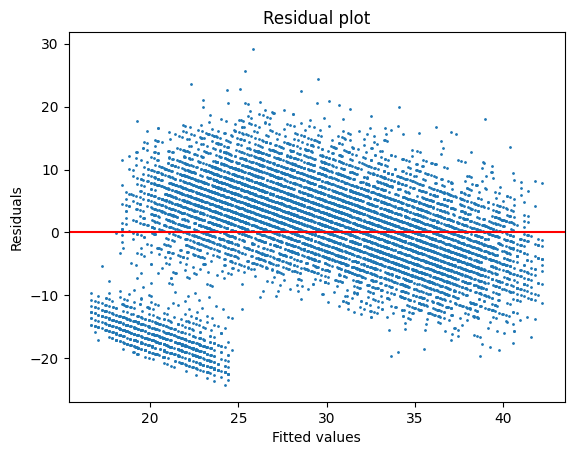

In [10]:
plt.scatter(model.predict(X_norm), model.resid, s = 1)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.axhline(y = 0, c = "red")
plt.show()

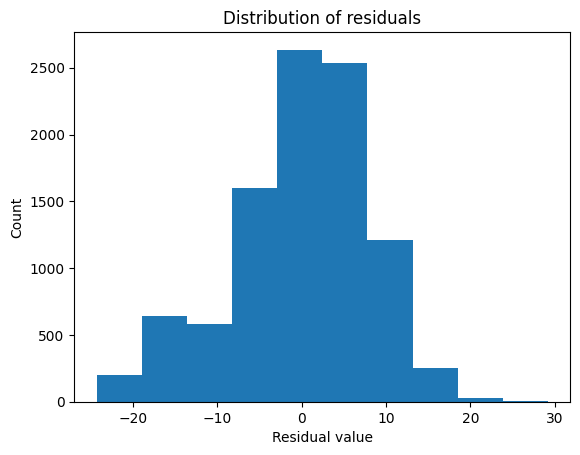

In [18]:
plt.hist(model.resid)
plt.ylabel("Count")
plt.title("Distribution of residuals")
plt.xlabel("Residual value")
plt.show()

It appears that the residuals are skewed to the right.

In [12]:
from statsmodels.graphics.gofplots import qqplot

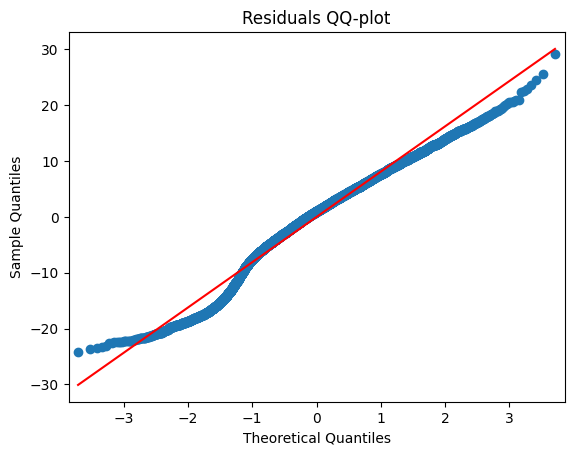

In [13]:
qqplot(model.resid, line = 's')
plt.title("Residuals QQ-plot")
plt.show()

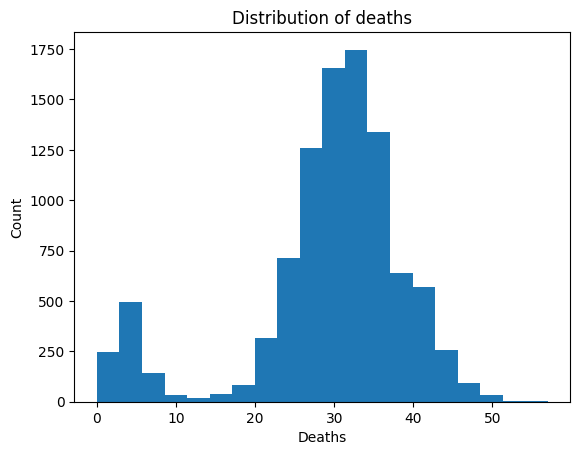

In [17]:
plt.hist(y, bins = 20)
plt.title("Distribution of deaths")
plt.ylabel("Count")
plt.xlabel("Deaths")
plt.show()

The skew of the residuals is likely caused by the combinations of features that were very effective and achieved really low number of deaths.